In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import norm as gaussian

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


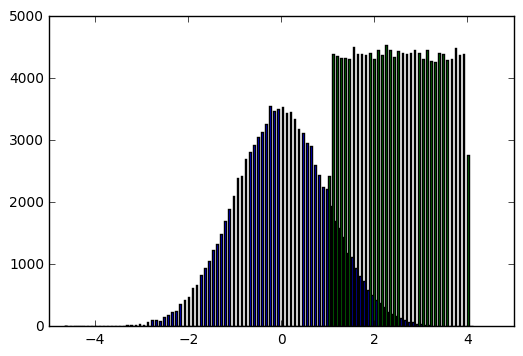

In [274]:

#x = [np.random.randn(n) for n in nx]
nx = [int(1e5), int(1.5e5)]
x = [np.random.randn(nx[0]), np.random.rand(nx[1])]
x[1] *= 3.
x[1] += 1 + 0.00 * np.random.randn(len(x[1]))

# nx = [int(1.5e5), int(1e5)]
# x = [np.random.rand(nx[0]), np.random.randn(nx[1])]
# x[0] *= 3
# x[0] -= 4
plt.hist(x, 100);

In [275]:
# Join together to  make  training-like data
ypred = np.concatenate(x).flatten()
y = np.zeros(np.sum(nx))
y[0:nx[0]] = 0.
y[nx[0]:] = 1.
# Set up a classifier
classifier = linearBinaryClassifier(y, ypred, npts=500)
# Do classification
classifier.setupThreshold()
yclass = classifier.classify(ypred)

In [276]:
(yclass != y).mean()
1 - classifier.confidence(ypred).mean()

0.089660401298702563

In [265]:
from scipy.interpolate import interp1d

class linearBinaryClassifier():
    """
    A simple class for deciding basic classification of binary data along one dimension
    """
    def __init__(self, y, ypred, npts=200):
        """
        """
        self.npts = npts
        self.y = y
        mask = (y == 0)

        self.ymin = ypred.min()
        self.ymax = ypred.max()
        
        # Split up ypred into the 2 classes
        self.ypred = [ypred[mask], ypred[~mask]]
        # 
        self.ntot = len(ypred)
        self.ny = [len(yi) for yi in self.ypred]
        # Get spline functions for how many are less than y
        self.ysorted = [np.sort(yi) for yi in self.ypred]
        self.nless = [interp1d(self.ysorted[i], np.arange(self.ny[i]), kind='nearest', fill_value='extrapolate', 
                               bounds_error=False, assume_sorted=False) for i in range(2)]
    
    def _scaleprob(self, p, pmin):
        """
        Re-scales the probabilities such that p.max() is preserved but p <= pmin goes to zero
        
        to avoid some edge cases, pmin >= p.max() sets pmin=0
        """
        pmax = p.max()
        if pmin >= pmax:
            pmin = 0.
        p = pmax * (p - pmin)/(pmax - pmin)
        p[p < 0] = 0
        return p
        
    def setupThreshold(self):
        """
        setup the threshold and confidences
        """
        self.yline = np.linspace(self.ymin, self.ymax, self.npts)
        # Number of 1s less than y
        n1lt = self.nless[1](self.yline)
        # number of 0s greater than y
        n0gt = self.ny[0] - self.nless[0](self.yline)
        # Prediction error as a function of threshold
        error = n0gt + n1lt
        self.iThreshold = error.argmin()
        self.threshold = self.yline[self.iThreshold]
        # approx prob (really the CDF) of being in 1
        prob1 = n1lt/(n1lt + n0gt)
        prob = [1-prob1, prob1]
        # Rescale to get the 'confidence'
        i0 = self.iThreshold
        i1 = min(self.npts-1, i0+1)
        boundaryProbs = [0.5 * (probi[i0] + probi[i1]) for probi in prob]
        conf = [self._scaleprob(prob[i], boundaryProbs[i]) for i in range(2)]
        # Set up confidence splines
        self.conf = [interp1d(self.yline, confi, kind='nearest', fill_value='extrapolate', bounds_error=False) \
                     for confi in conf]
        
        self._prob = prob
        self._confarrays = conf
        self._error = error
        
    def classify(self, ypred):
        """
        classify ypred.  ypred > self.threshold gives 1, else gives 0
        """
        ypred = np.asarray(ypred)
        yclass = np.zeros(ypred.shape)
        yclass[ypred > self.threshold] = 1
        return yclass
    
    def confidence(self, ypred):
        """
        Assign a confidence of the classification of ypred
        """
        ypred = np.asarray(ypred)
        yclass = self.classify(ypred)
        conf = np.zeros(ypred.shape)
        mask = (yclass == 0)
        conf[mask] = self.conf[0](ypred[mask])
        conf[~mask] = self.conf[1](ypred[~mask])
        return conf
    
        

3.39775409992 3.2786796186


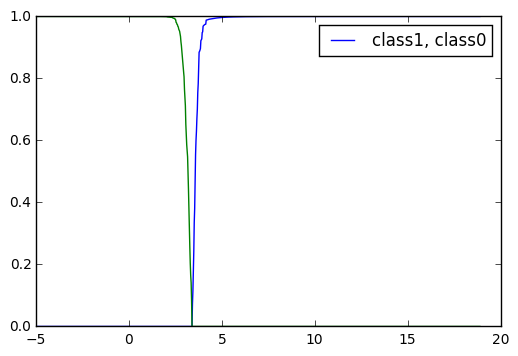

In [114]:
xmin = min([xi.min() for xi in x])
xmax = max([xi.max() for xi in x])
xline = np.linspace(xmin, xmax,1000)
# Prediction error as a function of threshold
error = nx[0] - nless[0](xline) + nless[1](xline);
# prob. of being in 1 vs x
n1lt = nless[1](xline)
n0gt = nx[0] - nless[0](xline)
prob1 = n1lt/(n1lt + n0gt)
# Thresholds from error and prob1
threshold1 = xline[error.argmin()]
threshold2 = xline[abs(prob1-0.5).argmin()]
print threshold1, threshold2
# get confidence of being in class 1
p1max = prob1.max()
p1min = prob1[error.argmin()]
confidence1 = p1max * (prob1 - p1min)/(p1max - p1min)
confidence1[confidence1 < 0] = 0.
# Get confidence of being in class 0
prob0 = 1 - prob1
p0max = prob0.max()
p0min = prob0[error.argmin()]
confidence0 = p0max * (prob0 - p0min)/(p0max - p0min)
confidence0[confidence0 < 0] = 0.
plt.plot(xline, confidence1, xline, confidence0)
plt.legend(['class1, class0'])

In [51]:
# Classification by assuming gaussians
# Distribution parameters
mu = [xi.mean() for xi in x]
sigma = [xi.std() for xi in x]
# Find where the probability of being in either dist is equal (weighted by the number of data points in each?)
a = (sigma[0]**2 - sigma[1]**2)
b = -2 * ((sigma[0]**2)*mu[1] + (sigma[1]**2) * mu[0])
c = (sigma[0]**2) * (mu[1]**2) - (sigma[1]**2) * (mu[0]**2) - (sigma[0]**2) * (sigma[1]**2) * np.log(nx[1]*sigma[0]/(nx[0]*sigma[1]))

thresholds = [(-b + np.sqrt(b**2 - 4 * a * c))/(2*a), (-b - np.sqrt(b**2 - 4 * a * c))/(2*a)]
print thresholds

[-397.24929939037997, 0.38748050584882443]
